In [11]:
import pandas as pd
from datetime import datetime, date, timedelta
from requests import post
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(1, '../src/')
from basebot import BaseBot

In [3]:
bot = BaseBot("testbot")

df = bot.getData(ticker = "IWDA.AS", start_date = datetime(2010,1,1), technical_indicators=["all"])
df = bot.getTrend(df)
df.head()

,ticker,open,high,low,close,volume,adj_close,volume_adi,volume_obv,volume_cmf,...,momentum_kama,others_dr,others_dlr,others_cr,SMA_3,SMA_10,SMA_50,SMA_100,SMA_200,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-12,IWDA.AS,42.455002,42.674999,42.455002,42.575001,53831,42.575001,4893.896985,53831.0,0.090912,...,42.575001,-25.658017,0.433580,0.434522,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-13,IWDA.AS,42.540001,42.759998,42.445000,42.759998,73915,42.759998,78808.896985,127746.0,0.616919,...,42.649766,0.434522,0.433580,0.434522,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-14,IWDA.AS,42.730000,42.860001,42.689999,42.840000,19521,42.840000,93736.668981,147267.0,0.636508,...,42.724116,0.187095,0.186920,0.622430,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-15,IWDA.AS,42.674999,42.689999,42.470001,42.575001,25357,42.575001,92584.257942,121910.0,0.536335,...,42.662290,-0.618579,-0.620500,0.364061,42.725,42.7965,44.072,None,45.01955,1.0
2017-09-18,IWDA.AS,42.779999,42.860001,42.669998,42.730000,44301,42.730000,76263.117764,166211.0,0.351564,...,42.689158,0.364061,0.363399,0.364061,42.715,42.7965,44.072,None,45.01955,1.0


In [4]:
df["signal"].value_counts()

 1.0    862
-1.0    435
Name: signal, dtype: int64

-1 represents sell (downtrend), 1 buy (uptrend), 0 is not yet decided

## simulate best possible scenario

(following signal)

<AxesSubplot:xlabel='timestamp'>

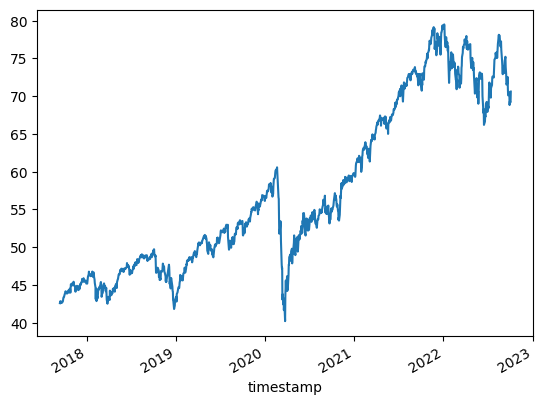

In [5]:
df["adj_close"].plot()

In [7]:
## calculate timespan
days = (df.index[-1] - df.index[0]).days
print("index takes %d days" % days)

index takes 1848 days


In [9]:
## baseline
startMoney = 10000
COMMISSION = 0.00025
nrStocks = startMoney / df.iloc[0]["adj_close"]
print("you would have bought {} stocks".format(nrStocks))
baselineWin = df.iloc[-1]["adj_close"] * nrStocks - startMoney
print("just holding would have given you %.2f$" % baselineWin)
baselineWinPerMonth = baselineWin / days * 30
print("or %.2f$ per month" % baselineWinPerMonth)

you would have bought 234.87961998358358 stocks
just holding would have given you 6582.50$
or 106.86$ per month


following the signal would have given you 24914.74$
or 404.46$ per month


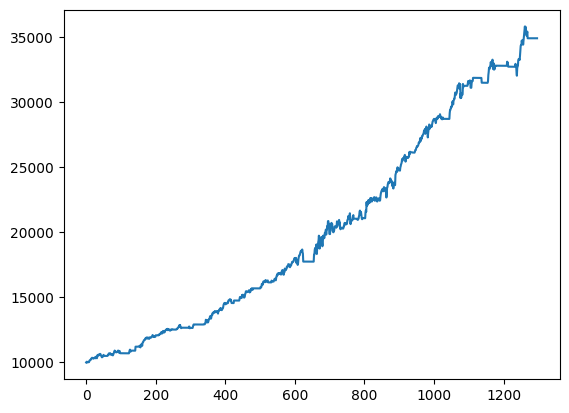

In [12]:
## next check if we follow signal what the best scenario would have been
money = startMoney
nrStocks = 0
bestPortfolio = []
for i in range(len(df)):
    if df.iloc[i]["signal"] == 1 and money > 0 and nrStocks == 0:
        amount = money / df.iloc[i]["adj_close"] * .99
        cost = amount * df.iloc[i]["adj_close"] * (1 + COMMISSION)
        money -= cost
        nrStocks += amount
    elif df.iloc[i]["signal"] == -1 and nrStocks > 0:
        money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
        nrStocks = 0
    bestPortfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
# last day sell nrStocks
money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
nrStocks = 0

win = money - startMoney
print("following the signal would have given you %.2f$" % win)
winPerMonth = win / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestPortfolio)